In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from harmonic_mixture_sampler import GaussianMixtureSwapper
from bayes_adaptive_fitter import BayesAdaptor 
from adaptive_tools import *

# Example for Bayesian adaptive method

This notebook demostrates the functionality of the `BayesAdaptor` class, which provides all of the tools necessary for adaptive Bayesian estimation of free energies. `BayesAdaptor` takes state counts from multinomial mixture sampling, performs Bayesian estimation of the free energies, and generates biasing potentials for the next round of mixture sampling to ensure subsequent data is maximally informative.

### Hyperparameters for adaptive method 

In [2]:
# Defining the prior information.
prior = 'gaussian'
spread = 10.0
location = 0.0

# The zeta sampling scheme
method = 'thompson'
logistic = False

# Number of adaptive cycles
ncycles = 50

# Number of iterations and data thinning from Gaussian mixture sampling
niterations = 250
save_freq = 50
print 'Total number of counts per cycle:', niterations/save_freq

# Emcee parameters for sampling from the posterior distribution of free energies
nmoves = 500
nwalkers = 10
burnin = 100

Total number of counts per cycle: 5


## Adaptive estimate for 2 state system

In [3]:
# Generating the target free energy from the prior
f_true = gen_free_energy(prior, spread, location, size=1)
sigmas = gen_sigmas(1.0, f_true)

# The initial biasing potential and counts
zetas = [[0.0, 0.0]]
counts = []

# Pre-assigment for data collection
map_estimate = []
median = []
lowerq = []
upperq = []

print 'Target:', f_true[0]
for i in range(ncycles):
    # Sample from mixture
    sampler = GaussianMixtureSwapper(sigmas=sigmas, zetas=zetas[i])
    sampler.sample_mixture(niterations=niterations, save_freq=save_freq)
    counts.append(sampler.state_counter)
    # Sample from the posterior
    adaptor = BayesAdaptor(zetas=np.array(zetas), counts=np.array(counts), prior=prior, spread=spread, location=location)
    adaptor.sample_posterior(nwalkers=nwalkers, nmoves=nmoves)
    # Sample a new biasing potential
    zetas.append([0, adaptor.gen_biases(method=method, logistic=logistic)])
    # Collect data
    m = np.percentile(adaptor.flat_samples, 50)
    mp = adaptor.map_estimator(f_guess=np.hstack((0.0, m)))
    map_estimate.append(mp)
    median.append(m)
    lowerq.append(np.percentile(adaptor.flat_samples, 97.5))
    upperq.append(np.percentile(adaptor.flat_samples, 2.5))

Target: 23.1013492338


### Plotting results
Viewing the median (thick line), true free energy (dotted line), and 95% credible region (light color).

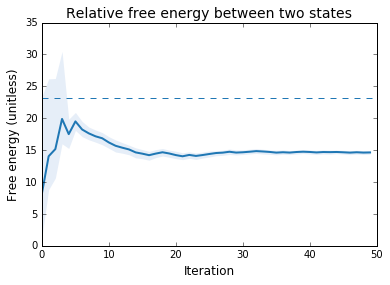

In [4]:
x = range(len(median))
color = 0
plt.clf()
plt.plot(x, median, color=tableau4[color], lw=2)
plt.axhline(y = f_true, color=tableau4[color], ls='--', lw=1)
plt.fill_between(x,lowerq, upperq, facecolor=tableau4_light[color], linewidth=0, alpha=0.3, interpolate=True)
plt.title('Relative free energy between two states', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Free energy (unitless)', fontsize=12)
plt.show()

## Adaptive estimate for 5 state system

In [5]:
# Generating the target free energy from the prior
f_true = gen_free_energy(prior, spread, location, size=4)
sigmas = gen_sigmas(1.0, f_true)

# The initial biasing potential and counts
zetas = [np.array([0.0, 0.0, 0.0, 0.0, 0.0])]
counts = []

# Pre-assigment for data collection
map_estimate = []
median = []
lowerq = []
upperq = []

print 'Target:', f_true
ncycles=40
for i in range(ncycles):
    # Sample from mixture
    sampler = GaussianMixtureSwapper(sigmas=sigmas, zetas=zetas[i])
    sampler.sample_mixture(niterations=niterations, save_freq=save_freq)
    counts.append(sampler.state_counter)
    # Sample from the posterior
    adaptor = BayesAdaptor(zetas=np.array(zetas), counts=np.array(counts), prior=prior, spread=spread, location=location)
    adaptor.sample_posterior(nwalkers=nwalkers, nmoves=nmoves)
    # Sample a new biasing potential
    zetas.append(np.hstack((0.0, adaptor.gen_biases(method=method, logistic=logistic))))
    # Collect data
    map_estimate.append(adaptor.map_estimator())
    median.append(np.percentile(adaptor.flat_samples, 50, axis=0))
    lowerq.append(np.percentile(adaptor.flat_samples, 97.5, axis=0))
    upperq.append(np.percentile(adaptor.flat_samples, 2.5,axis=0))
map_estimate = np.array(map_estimate)
median = np.array(median)
lowerq = np.array(lowerq)
upperq = np.array(upperq)

Target: [  1.63595262  -6.828223     2.46969253 -13.54831475]


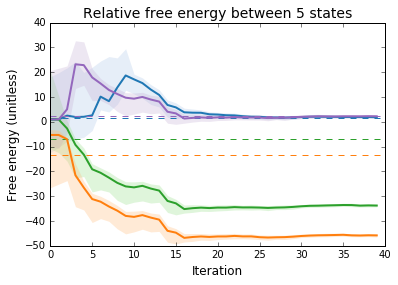

In [6]:
x = np.arange(map_estimate.shape[0])
for i in range(4):
    plt.plot(x, map_estimate[:,i], color=tableau4[i], lw=2)
    plt.axhline(y = f_true[i], color=tableau4[i], ls='--', lw=1)
    plt.fill_between(x, lowerq[:,i], upperq[:,i], facecolor=tableau4_light[i], linewidth=0, alpha=0.3, interpolate=True)
plt.title('Relative free energy between 5 states', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Free energy (unitless)', fontsize=12)
plt.show()

# Zeta sampling test
Does sampling $\zeta$ from a logistic distribution centered on the true value of $f$ decrease the variance of the posterior faster than sampling at the true value of $f$?.

In [7]:
# Generating the free energy and distribution from prior
f_true = gen_free_energy(prior, spread, location)[0]
sigmas = gen_sigmas(1.0, f_true)
print 'f_true =', f_true

# Setting the hyperparamters of the study
nrepeats = 1
ncycles = 1

f_true = 1.73019760927


### Setting $\zeta = f$

In [8]:
# Pre-assigment
bias_equal = []
variance_equal = []

nrepeats = 10
ncycles = 15
for r in range(nrepeats):
    zetas = [[0.0, f_true]]
    counts = []
    bias = []
    variance = []
    for i in range(ncycles):
        # Sample from mixture
        sampler = GaussianMixtureSwapper(sigmas=sigmas, zetas=zetas[i])
        sampler.sample_mixture(niterations=niterations, save_freq=save_freq)
        counts.append(sampler.state_counter)
        # Sample from the posterior
        fitter = MultinomialBayes(zetas=np.array(zetas), counts=np.array(counts), prior=prior, spread=spread, location=location)
        bayes_samps = fitter.sample_posterior(nwalkers=nwalkers, nmoves=nmoves)
        bayes_samps = bayes_samps[:, burnin:, :].reshape((-1))
        # Setting the new biasing potential to be the same as before
        zetas.append([0.0, f_true])
        # Collect data
        median = np.percentile(bayes_samps, 50)
        bias.append((f_true - fitter.map_estimator(f_guess=np.hstack((0.0, median)))[1])**2)
        variance.append(np.var(bayes_samps))
    bias_equal.append(np.array(bias))
    variance_equal.append(np.array(variance))
    print 'repeat {0} compete'.format(r)

NameError: name 'MultinomialBayes' is not defined

### Sampling $\zeta \sim \text{Logistic}(f)$

In [ ]:
# Pre-assigment
bias_logistic = []
variance_logistic = []

nrepeats = 10
ncycles = 15
for r in range(nrepeats):
    zetas = [[0.0, f_true]]
    counts = []
    bias = []
    variance = []
    for i in range(ncycles):
        # Sample from mixture
        sampler = GaussianMixtureSwapper(sigmas=sigmas, zetas=zetas[i])
        sampler.sample_mixture(niterations=niterations, save_freq=save_freq)
        counts.append(sampler.state_counter)
        # Sample from the posterior
        fitter = MultinomialBayes(zetas=np.array(zetas), counts=np.array(counts), prior=prior, spread=spread, location=location)
        bayes_samps = fitter.sample_posterior(nwalkers=nwalkers, nmoves=nmoves)
        bayes_samps = bayes_samps[:, burnin:, :].reshape((-1))
        # Sampling zeta from logistic distribution about f_true
        zetas.append([0, gen_zeta((f_true, f_true), 'logistic')])
        # Collect data
        median = np.percentile(bayes_samps, 50)
        bias.append((f_true - fitter.map_estimator(f_guess=np.hstack((0.0, median)))[1])**2)
        variance.append(np.var(bayes_samps))
    bias_logistic.append(np.array(bias))
    variance_logistic.append(np.array(variance))
    print 'repeat {0} compete'.format(r)

#### Collecting and plotting results

In [ ]:
bias_equal = np.array(bias_equal)
bias_logistic = np.array(bias_logistic)
variance_equal = np.array(variance_equal)
variance_logistic = np.array(variance_logistic)

In [ ]:
std_error_equal = np.array(variance_equal)

plt.plot(bias_equal.mean(axis=0))
plt.plot(bias_logistic.mean(axis=0))
plt.legend(('Equal','Logistic'))
plt.show()

In [ ]:
plt.plot(variance_equal.mean(axis=0))
plt.plot(variance_logistic.mean(axis=0))
plt.legend(('Equal','Logistic'))
plt.show()

In [ ]:
np.random.choice((2,3,4),size=1)